<a href="https://colab.research.google.com/github/Nicolas-Bolouri/OpenAi/blob/main/CartPole_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenAI’s CartPole-v1

## Installing dependencies

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.5 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## Importing dependencies and video helper function

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
import time, math, random
from typing import Tuple
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Task 1: Development of an RL agent

We start by loading the environment.

In [ ]:
env = gym.make("CartPole-v1")

For our Q-Learning model to function, we discretize the cart-pole states into finite categories. This simplification enables a manageable Q-table size, allowing the model to learn and optimize actions effectively within a discrete decision space.

In [ ]:
# Define the number of buckets for each state dimension
n_buckets = (10, 10, 10, 10)

# Define the bounds for each state dimension
lower_bounds = [-4.8, -3.0, -0.418, -math.radians(50)]
upper_bounds = [4.8, 3.0, 0.418, math.radians(50)]

# Calculate the width of each bucket
bucket_width = [(upper_bounds[i] - lower_bounds[i]) / (n_buckets[i] - 1) for i in range(4)]

def discretizer(cart_position, cart_velocity, pole_angle, pole_angular_velocity):
    """
    Converts continuous cart-pole state variables into discrete indexes based on predefined buckets.

    Parameters:
    - cart_position (float): The cart's position.
    - cart_velocity (float): The cart's velocity.
    - pole_angle (float): The pole's angle with respect to vertical.
    - pole_angular_velocity (float): The pole's angular velocity.

    Returns:
    Tuple[int, ...]: A tuple of discrete indexes for each input state variable.
    """
    cart_pos_index = int(min(max((cart_position - lower_bounds[0]) / bucket_width[0], 0), n_buckets[0] - 1))
    cart_vel_index = int(min(max((cart_velocity - lower_bounds[1]) / bucket_width[1], 0), n_buckets[1] - 1))
    pole_angle_index = int(min(max((pole_angle - lower_bounds[2]) / bucket_width[2], 0), n_buckets[2] - 1))
    pole_vel_index = int(min(max((pole_angular_velocity - lower_bounds[3]) / bucket_width[3], 0), n_buckets[3] - 1))

    return (cart_pos_index, cart_vel_index, pole_angle_index, pole_vel_index)

Initializing the Q-table with random values instead of zeros encourages initial exploration of the action space, preventing early bias towards any specific action and promoting a more diverse learning experience.

In [ ]:
Q_table = np.random.uniform(low=0, high=1, size=n_buckets + (env.action_space.n,))

Define the policy function to balance exploration and exploitation.




In [ ]:
def policy(state, epsilon=0.0):
    """
    Determines the action to take in a given state using an epsilon-greedy strategy.

    Parameters:
    - state: The current state of the environment.
    - epsilon (float, optional): The probability of choosing a random action for exploration.

    Returns:
    The action chosen based on the epsilon-greedy strategy.
    """
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

Define the function to update Q-values, enhancing reward optimization by considering future returns.

In [ ]:
def new_Q_value(reward, new_state, gamma):
    """
    Updates the Q-value for a state-action pair by incorporating future rewards.

    Parameters:
    - reward: The immediate reward received from taking an action.
    - new_state: The state transitioned into after taking the action.
    - gamma: The discount factor for future rewards.

    Returns:
    The updated Q-value incorporating future potential rewards.
    """
    future_optimal_value = np.max(Q_table[new_state])  # max_a Q(S', a)
    return reward + gamma * future_optimal_value

During training, extra rewards and punishments are given to train the AI better along with just the number of steps taken.

We defined our reward and punishment system in 3 stages

The first stage is based around logical deductions on what actions would be appropriate at a given state. This would allow the AI to quickly learn what actions are good and bad.

The second stage is based around incentivising the AI to remain in an optimal zone for position, velocity, pole angle and angular velocity. This portion builds on the first portion and fine tunes the robot to be able to balance well, rewarding stability in all 4 factors.

The last stage heavily punishes the robot if it was far from the center and still moving away from the center. This is due to the first two stages paying more focus to the balancing of the pole, which resulted in cases where the AI avoids changing directions due to the short term instability and insteads crashes into the environment's boundaries.

In [ ]:
def calculate_reward(action, current_obs, next_obs):
  reward = 0
  if action == 0 and current_obs[0] > 0.5: #if cart is close to right and action is to move left, give reward
    reward = reward + 3
  if action == 1 and current_obs[0] < -0.5:
    reward = reward + 3

  if action == 0 and current_obs[1] > 0.25: #if velocity moves right and action is to move left, give reward
    reward = reward + 5
  if action == 1 and current_obs[1] < -0.25:
    reward = reward + 5

  if action == 0 and current_obs[2] > 0: #if pole angle is leaning right and action is to move left, give punishment
    reward = reward - 10
  if action == 1 and current_obs[2] < 0:
    reward = reward - 10

  if action == 0 and current_obs[3] > 0.5: #if pole speed is moving right and action is to move left, give punishment
    reward = reward - 7
  if action == 1 and current_obs[3] < -0.5:
    reward = reward - 7



  if -0.25 < next_obs[0] < 0.25: #if cart is close to center, give reward
    reward = reward + 1
  elif -0.75 < next_obs[0] < 0.75:
    reward = reward + 0
  else:
    reward = reward - 1

  if -0.1 < next_obs[1] < 0.1: # if velocity is small, give reward
    reward = reward + 1
  elif -0.25 < next_obs[1] < 0.25:
    reward = reward + 0
  else:
    reward = reward - 1

  if -0.05 < next_obs[2] < 0.05: # if pole angle is small (in other words, pole is not leaning much), give reward
    reward = reward + 5
  elif -0.1 < next_obs[2] < 0.1:
    reward = reward + 0
  else:
    reward = reward - 5

  if -0.5 < next_obs[3] < 0.5: #if pole's rotation is small, give reward
    reward = reward + 5
  elif -1 < next_obs[3] < 1:
    reward = reward + 0
  else:
    reward = reward - 5

  #If too far too the left and velocity towards left, give punishment
  if next_obs[0] < -1 and next_obs[1] < 0:
    reward = reward - 5

  #If too far too the right and velocity towards right, give punishment
  if next_obs[0] > 1 and next_obs[1] > 0:
    reward = reward - 5
  return reward

Now that all helper functions have been definined, the following code block trains our model. Training our model involves running it through a series of episodes to learn the optimal actions at different states under a given policy. The process starts with high exploration (high epsilon) to explore a wide range of actions, gradually shifting towards exploitation (lower epsilon) as the model learns from the environment. Parameters like alpha (learning rate), gamma (discount factor for future rewards), and the dynamics of epsilon (for balancing exploration and exploitation) are set to guide this learning process. Throughout each episode, the agent's observations and actions are used to update the Q-table values, continuously refining the policy towards optimal action selection based on the observed states. This iterative process of adjustment and learning aims to enhance the model's decision-making ability, leveraging immediate feedback and projected future outcomes to inform actions in a complex, dynamic environment.

In [ ]:
alpha = 0.1  # Fixed step size
gamma = 1  # Discount factor
epsilon_start = 1.0  # Starting value of epsilon
epsilon_decay = 0.999  # Decay rate of epsilon after each episode
epsilon_min = 0.01  # Minimum value of epsilon

n_episodes = 10000
for e in range(n_episodes):
    epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** e))  # Decrease epsilon
    current_obs, done = env.reset(), False
    time = 0

    while not done:
        current_state = discretizer(*current_obs)
        action = policy(current_state, epsilon)  # Use the epsilon-greedy policy
        next_obs, reward, done, _ = env.step(action)
        new_state = discretizer(*next_obs)
        time = time + 1
        reward = calculate_reward(action, current_obs, next_obs)

        if time > 500:
          done = True

        # Update Q-Table using the formula from the uploaded algorithm
        old_value = Q_table[current_state][action]
        learnt_value = new_Q_value(reward, new_state, gamma)
        Q_table[current_state][action] = (1 - alpha) * old_value + alpha * learnt_value

        current_obs = next_obs  # Update the observation

env.close()

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation = env.reset()
action = policy(discretizer(*observation))
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.03469022  0.00561753  0.018377    0.00742471]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

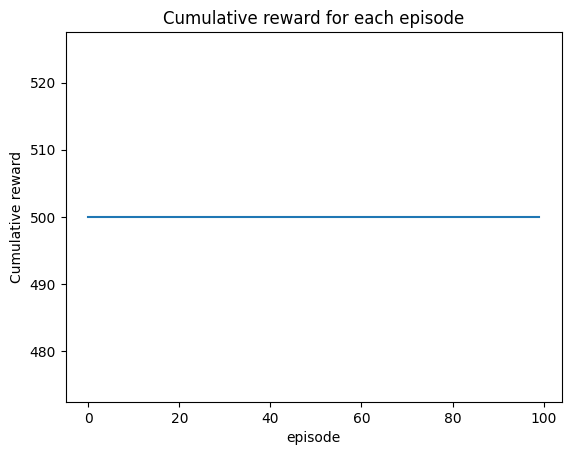

In [ ]:
episode_results = np.array([])

for _ in range(100):

  observation = env.reset()
  cumulative_reward = 0
  done = False

  while not done:
      action = policy(discretizer(*observation))
      observation, reward, done, info = env.step(action)
      cumulative_reward += reward

  episode_results = np.append(episode_results, cumulative_reward)

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    state = discretizer(*observation)
    action = policy(state)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
